# How to Subset and Download Level 2 GES DISC Data Using Harmony-py

### Overview

This notebook uses the `harmony-py` library to query, subset, and download MERRA-2 [M2I3NPASM.5.12.4](https://disc.gsfc.nasa.gov/datasets/M2I3NPASM_5.12.4/summary?keywords=M2I3NPASM) granules. The subsetted granules cover the spatiotemporal extent of Hurricane Katrina at peak strength, and a plot containing wind vectors and temperature at the first time step is created.

This notebook was written using Python 3.10, and requires these libraries and files:

- Earthdata Login Account: https://urs.earthdata.nasa.gov/users/new
- [Harmony](https://harmony-py.readthedocs.io/en/main/)
- [xarray](https://docs.xarray.dev/en/stable/) (must be >=2025.4.0)
- [earthaccess](https://earthaccess.readthedocs.io/en/latest/quick-start/)
- [Matplotlib](https://matplotlib.org/)

#### Optional Anaconda Environment YAML:

This notebook can be run using the ['nasa-gesdisc' YAML file](https://github.com/nasa/gesdisc-tutorials/tree/main/environments/nasa-gesdisc.yml) provided in the 'environments' subfolder.

Please follow the instructions [here](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file) to install and activate this environment. 


### 1. Import Libraries

In [1]:
from harmony import Dimension, Client, Collection, Request, BBox
from datetime import datetime
import earthaccess
import xarray as xr
import os
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Create Client using Earthdata Login Credentials

This section will prompt the user for their Earthdata Login username and password and save them to a `.netrc` file if it does not already exist.
Then, a Harmony Client object is created, using the credentials inside the `.netrc` file.

In [2]:
# Prompt for Earthdata Login credentials, store in a .netrc file if it does not exist
auth = earthaccess.login(strategy="interactive", persist=True)

harmony_client = Client()

### 3. Subset and Download Variables Along a Dimension

Harmony-py allows users to subset select variables from their desired collection, and along a range of dimensions. In this example, we demonstrate subsetting the M2I3NPASM MERRA-2 collection, which contains 42 pressure levels along a dimension titled `lev`. We can specify a range of pressure levels, select variables, and the bounding box to generate a map showing wind vectors and temperature of Hurricane Katrina approaching peak strength.

The collection short name must be specified, and its concept ID will be looked up using `earthaccess`. To find the short name of your desired collection, please visit the collection's [Dataset Landing Page](https://disc.gsfc.nasa.gov/datasets/M2I3NPASM_5.12.4/summary?keywords=M2I3NPASM_5.12.4).

#### 3a. Specify Collection and Subsetting Parameters

In [6]:
# Enter collection short name
short_name = "GPM_2ADPR"
version = "07"

# Define the spatial bounding box to be clipped
bbox = BBox(-97, 27, -93, 31)  # (west, south, east, north)

# Specify the start and end times in UTC
start = datetime(2017, 8, 27, 20, 0) # (year, month, day, hour, minute) 2017-08-27 20:00:00
stop = datetime(2017, 8, 27, 23, 59)

# Specify 1000-850 hPa pressure levels. This will not interpolate, but will find the nearest pressure level in the collection.
# Multiple Dimension variables can be added, and placed into a list in the dimensions parameter of the request
#lev_dimension = Dimension(name='lev', min=850, max=1000)

# Enter variables to be subsetted
variables = ["FS/SLV/precipRateNearSurface", "FS/Latitude", "FS/Longitude"]


#### 3b. Submit Request

We will create a Request object, check if it is valid, and submit the request. The request will not be downloaded until the next cell.

Once the request is completed without errors, we can print a URL showing the full subset that can be queried using tools like `wget` or `curl`, and we can print the size of the output files before we download them.

In [7]:
temporal = {
    "start": start,
    "stop": stop
}

# Query the CMR for the collection concept ID
concept_id = earthaccess.search_datasets(short_name=short_name, version=version)[0].concept_id()

# Build request
request = Request(
    collection=Collection(concept_id),
    spatial=bbox,
    temporal=temporal,
    variables=variables
)

try:
    # Check if the request syntax is valid
    if not request.is_valid():
        print("Local validation error:", request.validation_messages)
    else:
        # Submit the request and monitor progress, outputting request URLs and the data size
        job_id = harmony_client.submit(request)
        harmony_client.wait_for_processing(job_id, show_progress=True)
        job_summary = harmony_client.result_json(job_id)
        print("Request URL:", job_summary["request"])
        print("Output Data Size:", job_summary["outputDataSize"])

except Exception as e:
    print("Harmony request failed:", e)


 [ Processing: 100% ] |###################################################| [|]


Request URL: https://harmony.earthdata.nasa.gov/C2179081499-GES_DISC/ogc-api-coverages/1.0.0/collections/parameter_vars/coverage/rangeset?forceAsync=true&subset=lat(27%3A31)&subset=lon(-97%3A-93)&subset=time(%222017-08-27T20%3A00%3A00%22%3A%222017-08-27T23%3A59%3A00%22)&label=harmony-py&variable=FS%2FSLV%2FprecipRateNearSurface&variable=FS%2FLatitude&variable=FS%2FLongitude
Output Data Size: 285.21 KiB


#### 3c. Download Subsets as NetCDF4

By default, Harmony-py will subset Level 3 and 4 collections as NetCDF4 files. Here, we specify the directory to download the subsetted files to, setting `overwrite=False` to skip overwriting existing files.

In [8]:
# Specify download directory
directory = "./Hurricane_Harvey_Subset"

# Create directory if it doesn’t exist
os.makedirs(directory, exist_ok=True)

# Download subsetted files asynchronously
futures = harmony_client.download_all(job_id, directory=directory, overwrite=False)

# Print file paths
filelist = [f.result() for f in futures]

./Hurricane_Harvey_Subset/119189608_2A.GPM.DPR.V9-20211125.20170827-S202340-E215612.019870.V07A_subsetted.HDF5


### 4. Open Files and Plot with Xarray

After we download the files, we can open them into a single Xarray dataset object, and create our map.

In [14]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [ ]:
ds = xr.open_dataset("./Hurricane_Harvey_Subset/119189608_2A.GPM.DPR.V9-20211125.20170827-S202340-E215612.019870.V07A_subsetted.HDF5",
                    group="FS/SLV", engine="h5netcdf")


<xarray.Dataset> Size: 2MB
Dimensions:                (phony_dim_31: 7932, phony_dim_32: 49)
Dimensions without coordinates: phony_dim_31, phony_dim_32
Data variables:
    precipRateNearSurface  (phony_dim_31, phony_dim_32) float32 2MB ...

In [26]:
ds_lon = xr.open_dataset("./Hurricane_Harvey_Subset/119189608_2A.GPM.DPR.V9-20211125.20170827-S202340-E215612.019870.V07A_subsetted.HDF5",group="FS", engine="h5netcdf")['Longitude']
ds_lat = xr.open_dataset("./Hurricane_Harvey_Subset/119189608_2A.GPM.DPR.V9-20211125.20170827-S202340-E215612.019870.V07A_subsetted.HDF5",group="FS", engine="h5netcdf")['Latitude']


                

In [34]:
ds_lon.values

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ..., -94.10236 , -94.05216 ,
        -94.00185 ],
       [       nan,        nan,        nan, ..., -94.081696, -94.03151 ,
        -93.98121 ],
       [       nan,        nan,        nan, ...,        nan,        nan,
        -93.96059 ]], dtype=float32)

In [ ]:
ds['precipRateNearSurface'].plot(x=ds_lon, y=ds_lat)

KeyError: 'Longitude'

ValueError: 'c' argument has 388668 elements, which is inconsistent with 'x' and 'y' with size 5292.

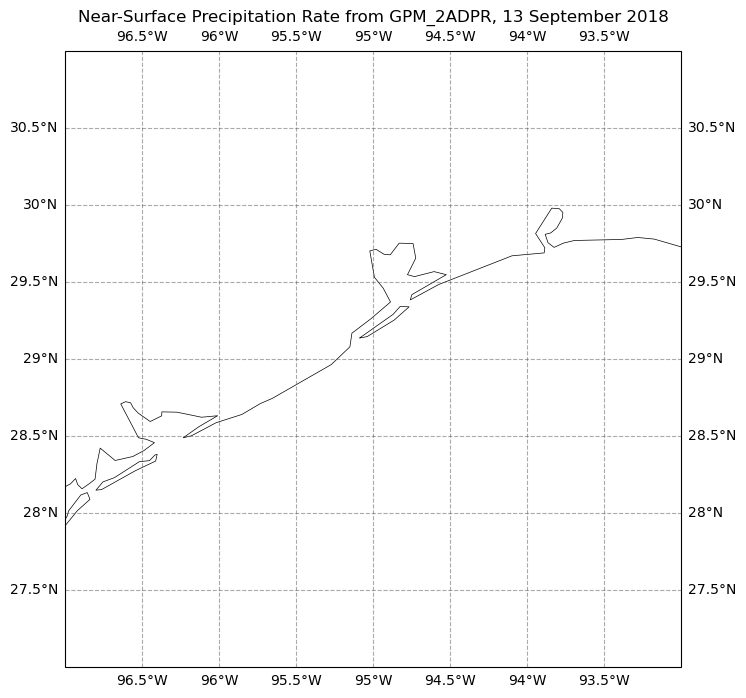

In [16]:
file = './Hurricane_Harvey_Subset/119189608_2A.GPM.DPR.V9-20211125.20170827-S202340-E215612.019870.V07A_subsetted.HDF5'
f = h5py.File(file,"r")
prns = f['/FS/SLV/precipRateNearSurface']
lon  = f["/FS/Longitude"]
lat  = f["/FS/Latitude"]

# 2-Dimensional Near-Surface Precipitation Rage
prnsdata = np.ndarray(shape=prns.shape,dtype=float)
prns.read_direct(prnsdata)
np.place(prnsdata, prnsdata==prns.attrs.get('_FillValue'), np.nan)

# Draw the subset of near-surface precipitation rate 
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-97,-93,27,31])
plt.title('Near-Surface Precipitation Rate from GPM_2ADPR, 13 September 2018')

# Add coastlines and gridlines
ax.coastlines(resolution="50m",linewidth=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,
                  linewidth=0.8,color='#555555',alpha=0.5,linestyle='--')
# Axis labels
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = True

# Plot the scatter diagram 
pp = plt.scatter(lon, lat, c=prnsdata, cmap=plt.cm.Spectral_r, transform=ccrs.PlateCarree())

# Add a colorbar to the bottom of the plot.
fig.subplots_adjust(bottom=0.15,left=0.06,right=0.94)
cbar_ax = fig.add_axes([0.12, 0.11, 0.76, 0.025])  
cbar = plt.colorbar(pp,cax=cbar_ax,orientation='horizontal')
cbar.set_label(label=prns.attrs.get('units').decode('utf-8'),size=10)

In [20]:
prnsdata.shape

(7932, 49)